## Notes and ideas :
- look for the frequency of publication of articles.
#### Features to be included in the template:
- Images with more weighting than the body of the article ( they may contain more information and impact on the reader).
- Measure the degree of objectivity or subjectivity (using the Vader metric) of bbc news writers by calculating the average distance of a bbc article from neutralitypoint (this could be done by applying the prediction model on more various categories -hence more data injected) , input this into your main model.
- Count the number of authors and see if studying each author separately is efficient, knowing that no much writters write in the climate rubrique.
- A picture (if subjective) is worth a thousand words", but if it is not significant, i.e. objective, it has no impact, no matter how much we consider it, the final result will not be affected. so we multiply the picture text (not a thousand times ofc hhh) to ponder with the rest of the article content.
- study the sentiment of news about some emerging notion : metaverse (in cathefories and NER) maybe something else.
## Insight :
- Transfer learning is already applied, make sure in the insight that you offer a path to relearn the Vader program to articles similar to bbc news.  

In [1]:
import os
import csv
import json
import nltk
import time
import spacy 
import shutil
import logging
import requests
import matplotlib
import numpy as np
import random as rd
import pandas as pd
import urllib.request
from PIL import Image
import networkx as nx
from spacy import displacy
from tqdm.notebook import *
import plotly.express as px
from bs4 import BeautifulSoup
from itertools import groupby
from spacy.tokens import Span 
from selenium import webdriver
import matplotlib.pyplot as plt
from newsapi import NewsApiClient
from spacy.matcher import Matcher 
nlp = spacy.load("en_core_web_sm")
from urllib.request import urlopen
from typing import List, Tuple, Dict
from matplotlib.pyplot import figure
from nltk.tag import StanfordNERTagger
from nltk.tokenize import word_tokenize
from stanfordcorenlp import StanfordCoreNLP
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.firefox.options import Options as FirefoxOptions

# I- Fetching data :

Used to fetch news data using an original scrapper, including published images, so they be injected into the model as additional features  

In [ ]:
def scrap_one_article(url, _, nbr_articles) -> Dict:
    
    #Function that scrapps one article's data and zipps it into a dictionary 
    url_clean = url
    if url[6:19] == url[26:39]:
        url_clean = url[19:]
        print(url_clean)
    options = FirefoxOptions()
    #options.add_argument("--headless")
    driver = webdriver.Firefox(options=options)
    driver.get("https://www.bbc.com/news/science-environment-56837908")
    csv_file = open('bbc_news.csv', 'a')
    csv_writer = csv.writer(csv_file)
    author = 'BBC News'
    title = None
    csv_writer.writerow(['id', 'url', 'author', 'article_content','images descriptions'])
    #Certain articles do miss some elements, they are rare. 
    try:
        author = soup.find_all(class_ = 'ssrcss-1rv0moy-Contributor')[0].find('strong').text[3:]
    except:
        pass
    try:
        title = soup.find_all(class_ = 'ssrcss-gcq6xq-StyledHeading')[0].text
    except: 
        pass
    try:
        date = soup.find_all(class_ = 'ecn1o5v2')[0].find('time')['datetime'][:10]
    except: 
        date = None
    try:
        cathegory = soup.find_all(class_ = 'ed0g1kj0')[0].text
    except: 
        cathegory = 'General'
    Content_list = soup.find_all(class_ = 'eq5iqo00')
    article_content = build_text(Content_list)
    try:
        article_content = article_content.strip('There\'s something for everyone on iPlayer\nIncluding Frozen, Moana, Worzel Gummidge and more...','')
        article_content = article_content.strip('If you are reading this page and can\'t see the form you will need to visit the mobile version of the BBC website to submit your question or comment or you can email us at HaveYourSay@bbc.co.uk. Please include your name, age and location with any submission','')
    except:
        pass
    if article_content[:28] == 'This video can not be played':
        article_content = article_content[29:]
    Images_descriptions = download_images_description(soup)    
    print('Article ', _,' - ',f'[{date}] [{cathegory}][{author}].')
    article_dic= {'id': _ -1,'url': url_clean,'author':author,'date': date,'cathegory':cathegory,'title':title,'article_content':article_content, 'Image count': len(Images_descriptions), 'images descriptions':Images_descriptions}
    return article_dic

In [ ]:
#tools
def build_text(list_) -> str:
    
    #building a text from a list 
    list_.pop()
    return '\n'.join([x.text for x in list_])
def dl_img(url, file_path, file_name) -> str:
    full_path = file_path + file_name + '.jpg'
    urllib.request.urlretrieve(url, full_path)
    return full_path
def download_images(soup_result,article_index,nbr_articles) -> int:
    
    #Downloading images from a links lists, then storing them locally ( within the server if it was hosted )
    nbr_img = 0
    try:
        os.mkdir(f'images/Article{article_index}')
    except:
        pass
    img_results = [res['src'] for res in soup_result.find_all('img')][-12:]
    print(len(img_results))
    for _ in tqdm (range(1,len(img_results))):
        image_link = img_results[_]
        image_link_loc = f'images/Article{article_index}/'
        file_name = f'img{_}'
        try:
            image_link_local = dl_img(image_link,image_link_loc, file_name)
            i += 1
            nbr_img+=1
        except:
            pass
        return nbr_img
def download_images_description(soup_result) -> List:
    
    #Downloading description of images.
    nbr_img = 0
    try:
        os.mkdir(f'images/Article{article_index}')
    except:
        pass
    img_results = [res['alt'] for res in soup_result.find_all('img')][-12:]
    img_results
    return img_results

In [ ]:
options = FirefoxOptions()
options.add_argument("--headless")
driver = webdriver.Firefox(options=options)
driver.get("https://www.bbc.com/news/science-environment-56837908")
links = []
def get_links_list(driver,page) -> List[str]:
        
    # Fetch all of the article's links from the BBC Climate url
    # Selinium is used as well to scroll the News Updates pages
    #for i in tqdm(range(50), desc = "Fetching all the links for climate articles"):
    if page ==21:
        pass
    while True:
        if driver.find_elements(By.CLASS_NAME,'qa-heading-link') != None:
            for _ in driver.find_elements(By.CLASS_NAME,'qa-heading-link') :
                links.append(_.get_attribute('href'))
            break
    while True:    
        try:
            WebDriverWait(driver, 1000).until(EC.element_to_be_clickable((By.CSS_SELECTOR, ".qa-pagination-next-page[rel='next']"))).click()
            break
        except:
            pass
    return get_links_list(driver,page)
links = get_links_list(driver,0)
def get_links_update():
    for _ in driver.find_elements(By.CLASS_NAME,'qa-heading-link') :
        if     
            links.append(_.get_attribute('href'))
update_links = get_links_update()

In [ ]:
def scrap_bbc_articles(category_url,links) -> List[Dict]:
    
    # Scrap all of the articles
    url = category_url
    response = requests.get(url)
    print('Request status (200 means a succesful request): ',response.status_code)
    soup = BeautifulSoup(response.text, 'lxml')
    print('fetching begun ...')
    print('Fetching data from ',len(links) - 5 ,' bbc news articles')
    results = []
    print('------------------------------------')
    for _ in tqdm(range(1,len(links)-5), desc = 'Fetching articles'):  # Covers all the articles len(links)+1
        try: 
            A = scrap_one_article(links[_], _, len(links))
            results.append(A)
        except:
            _ = _ +1
    return results

In [8]:
def scrap():
    climate_url = 'https://www.bbc.com/news/science-environment-56837908'
    data = scrap_bbc_articles(climate_url,links)
    def fetch_clean_data(data_list) -> List[Dict]: 

        #fetching data from articles
        article_results = [] 
        for i in range(len(data_list)):
            try:
                article_dict = {}
                article_dict['id'] = data_list[i]['id']
                article_dict['cathegory'] = data_list[i]['cathegory']
                article_dict['author'] = data_list[i]['author']
                article_dict['title'] = data_list[i]['title']
                article_dict['Publish date'] = data_list[i]['date']
                article_dict['url'] = data_list[i]['url']
                article_dict['article_content'] = data_list[i]['article_content'].strip("\n").strip("\t")
                article_dict['images descriptions'] = data_list[i]['images descriptions']
                article_results.append(article_dict)
            except IndexError:
                pass
        return article_results

In [2]:
def update_scrap():
    Data = pd.read_csv('exported_bbc_data-labelised.csv')
    pd.set_option('max_colwidth', 500)
    pd.set_option('max_colwidth', 100)
    print('Size of data : ', len(Data))
    return Data
Data = update_scrapte()

Size of data :  50


,Unnamed: 0,Unnamed: 0.1,id,cathegory,author,title,Publish date,url,article_content,images descriptions,sentiment,Named entities
0,0,0,0,COP26,Louise Cullen,Climate change: Will 2022 be the year NI gets legislation?,2022-01-02,https://www.bbc.com/news/uk-northern-ireland-59742532,Northern Ireland began 2021 without climate change legislation - and is ending the year with two...,"['Waterworks Park', 'A woman lifting weights', 'Man smiling', 'Police officers restrain a suppor...",3,"{'person': [Clare Bailey, Edwin Poots, Brexit, Taken, Waterworks, Antrim, Ruby Wax, Donald Trump..."
1,1,1,1,COP26,BBC News,EU plans to label gas and nuclear energy 'green' prompt row,2022-01-02,https://www.bbc.com/news/world-europe-59850093,"The European Commission has proposed plans to label some gas and nuclear power as green, prompti...","['A nuclear power plant in France', 'A woman lifting weights', 'Man smiling', 'Police officers r...",2,"{'person': [Steffi Lemke, Robert Habeck, Ruby Wax, Donald Trump], 'countries': 1 (Germany)\n..."
2,2,2,2,COP26,BBC News,Denmark to make domestic flights fossil fuel free by 2030,2022-01-02,https://www.bbc.com/news/world-europe-59849898,Denmark's government has announced a goal to make domestic flights fossil fuel free by 2030. \nI...,"['SAS airlines planes', 'A woman lifting weights', 'Man smiling', 'Police officers restrain a su...",1,"{'person': [Mette Frederiksen, Ms Frederiksen, Ruby Wax, Donald Trump], 'countries': 0 (Denm..."
3,3,3,3,General,BBC News,Title of article,2022-01-02,https://www.bbc.com/news/world-europe-59755739,A group of young men are using their gymnastic abilities to reduce the impact of light pollution...,"['Raven Cruz in Manila, Philippines', '', 'Luke and his daughter', 'Mel Chamberlain and a goat',...",3,"{'person': [Daniel South, Jasmin Souesi, Wizzy Gang], 'countries': 3 (France)\nName: Entities..."
4,4,4,4,General,BBC News,Title of article,2022-01-01,https://www.bbc.com/news/world-us-canada-59845176,Jennifer Gardner and her family are among tens of thousands of people who have been evacuated as...,"['Wildfire razes a Colorado house', 'Overlooking the mountains', 'Mel Chamberlain and a goat', '...",1,"{'person': [Jennifer Gardner], 'countries': 2 (US)\n3 (Colorado)\nName: Entities, dt..."
5,5,5,5,Our Planet Now,Justin Rowlatt,California's fires threaten to ravage mighty sequoia forests,2022-01-01,https://www.bbc.com/news/science-environment-59842464,California's giant sequoias are symbols of permanence - with some living for thousands of years....,"['Dixie fire devastation in Greenville', 'A woman lifting weights', 'Man smiling', 'Police offic...",3,"{'person': [Christy Bingham, Christy, Christy, Christy, Nichoel Farris, Nichoel, Christy, Christ..."
6,6,6,6,Climate change,BBC News,Colorado wildfires: Tens of thousands evacuated as blazes spread,2021-12-31,https://www.bbc.com/news/world-us-canada-59834897,"Tens of thousands of people have been evacuated and nearly 1,000 homes have been destroyed as wi...","[""Banner saying 'Get in touch'"", 'A woman lifting weights', 'Man smiling', 'Police officers rest...",1,"{'person': [Jared Polis, Gov Polis, Joe Biden, Joe Pelle, Snow, Gov Polis, Patrick Kilbride, Rub..."
7,7,7,7,Climate change,BBC News,Scotland's 100% renewables electricity target narrowly missed,2021-12-31,https://www.bbc.com/news/uk-scotland-59837782,Scotland narrowly missed a key environment target for the equivalent of 100% of electricity used...,"['wind turbines', 'A woman lifting weights', 'Man smiling', 'Police officers restrain a supporte...",1,"{'person': [Michael Matheson, Michael Matheson, Ruby Wax, Donald Trump], 'countries': 0 (Sco..."
8,8,8,8,General,BBC News,Title of article,2021-12-31,https://www.bbc.com/news/world-us-canada-59837697,Wildfires have devastated parts of Boulder County in the US state of Colorado. Tens of thousands...,"['Sofia', 'Wildlife officer Scott Murdoch', 'Mel Chamberlain and a goat', 'Boris Johnson', 'Man ...",1,"{'person': [], 'countries': 

<h1> II- Data preprocessing :</h1>

### 2.1 Introduction
Feature engineering is an important process in the pipeline of any machine learning project.
It involves applying a series of transformations to the data, including
data.
The motivation behind this process is to feed the algorithms with digested data
and to improve their performance by reducing the learning time.
In this project, different data processing techniques were applied to implement the NLP.

In [3]:
Data.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'id', 'cathegory', 'author', 'title',
       'Publish date', 'url', 'article_content', 'images descriptions',
       'sentiment', 'Named entities'],
      dtype='object')

In [ ]:
def clean(Data):
    Data["Publish date"].fillna( method ='ffill', inplace = True) # Fill NaN values
    Data["title"].fillna('Title of article', inplace = True) # won't be used anyways
    return Data
Data = clean(Data)
print(Data.columns)
Data = Data.drop(['url','Unnamed: 0','Unnamed: 0.1','id'],axis = 1)
Data.head()

### 2.3 NER : Named entities recognition :
As it is part of the task, we are asked to display sentiment analysis for each NER.
the aim of this sub-section is to try different Nlp models to get thelist of named entities from text.

In [19]:
index = 7
str_ = str(Data.iloc[index]['article_content']) # Article sample
str_

'Scotland narrowly missed a key environment target for the equivalent of 100% of electricity used in 2020 to be generated from renewable sources.\nOfficial figures show gross consumption from renewables - minus net exports - was 98.6%\nThe full 2020 total was up from 97.4% in the early part of the year. \nIt comes after the Scottish government missed a target for 11% of non-electrical heat to be generated by renewables in 2020.\nEnergy Secretary Michael Matheson said the country continued to "lead the way" with its commitment to be net zero by 2045.\nIn 2019, Scotland met 90.1% of its equivalent electricity consumption from renewables, according to Scottish government figures.\nThe 100% target was set in 2011, when renewable technologies generated just 37% of national demand.\nSome of Scotland\'s electricity is sold overseas, meaning it also uses significant amounts of non-renewable electricity.\nThe latest full-year figures also showed:\nOver the first nine months of 2021, provisional


#### 2.3.1 Spacy :

SpaCy is a Python software library for automatic language processing developed by Matt Honnibal and Ines Montani. SpaCy is open source software released under the MIT license. The SpaCy library can perform the following analysis operations on texts in over 50 languages : 
- Tokenization 
- NER


In [5]:
def get_Ner(str_) -> List[pd.DataFrame]:
    #using spacy to recognise named entites
    nlp = spacy.load("en_core_web_sm")
    doc = nlp(str_)
    entities = []
    labels = []
    position_start = []
    position_end = []
    for ent in doc.ents:
        entities.append(ent)
        labels.append(ent.label_)
        position_start.append(ent.start_char)
        position_end.append(ent.end_char)
    data_entities_2 = pd.DataFrame({'Entities':entities,'Labels':labels,'Position_Start':position_start, 'Position_End':position_end})
    persons_df = data_entities_2[['Entities','Labels']][(data_entities_2["Labels"] == 'PERSON')]
    country_df = data_entities_2[['Entities','Labels']][(data_entities_2["Labels"] == 'GPE')]
    org_df = data_entities_2[['Entities','Labels']][(data_entities_2["Labels"] == 'ORG')]
    return [data_entities_2,persons_df,country_df, org_df]

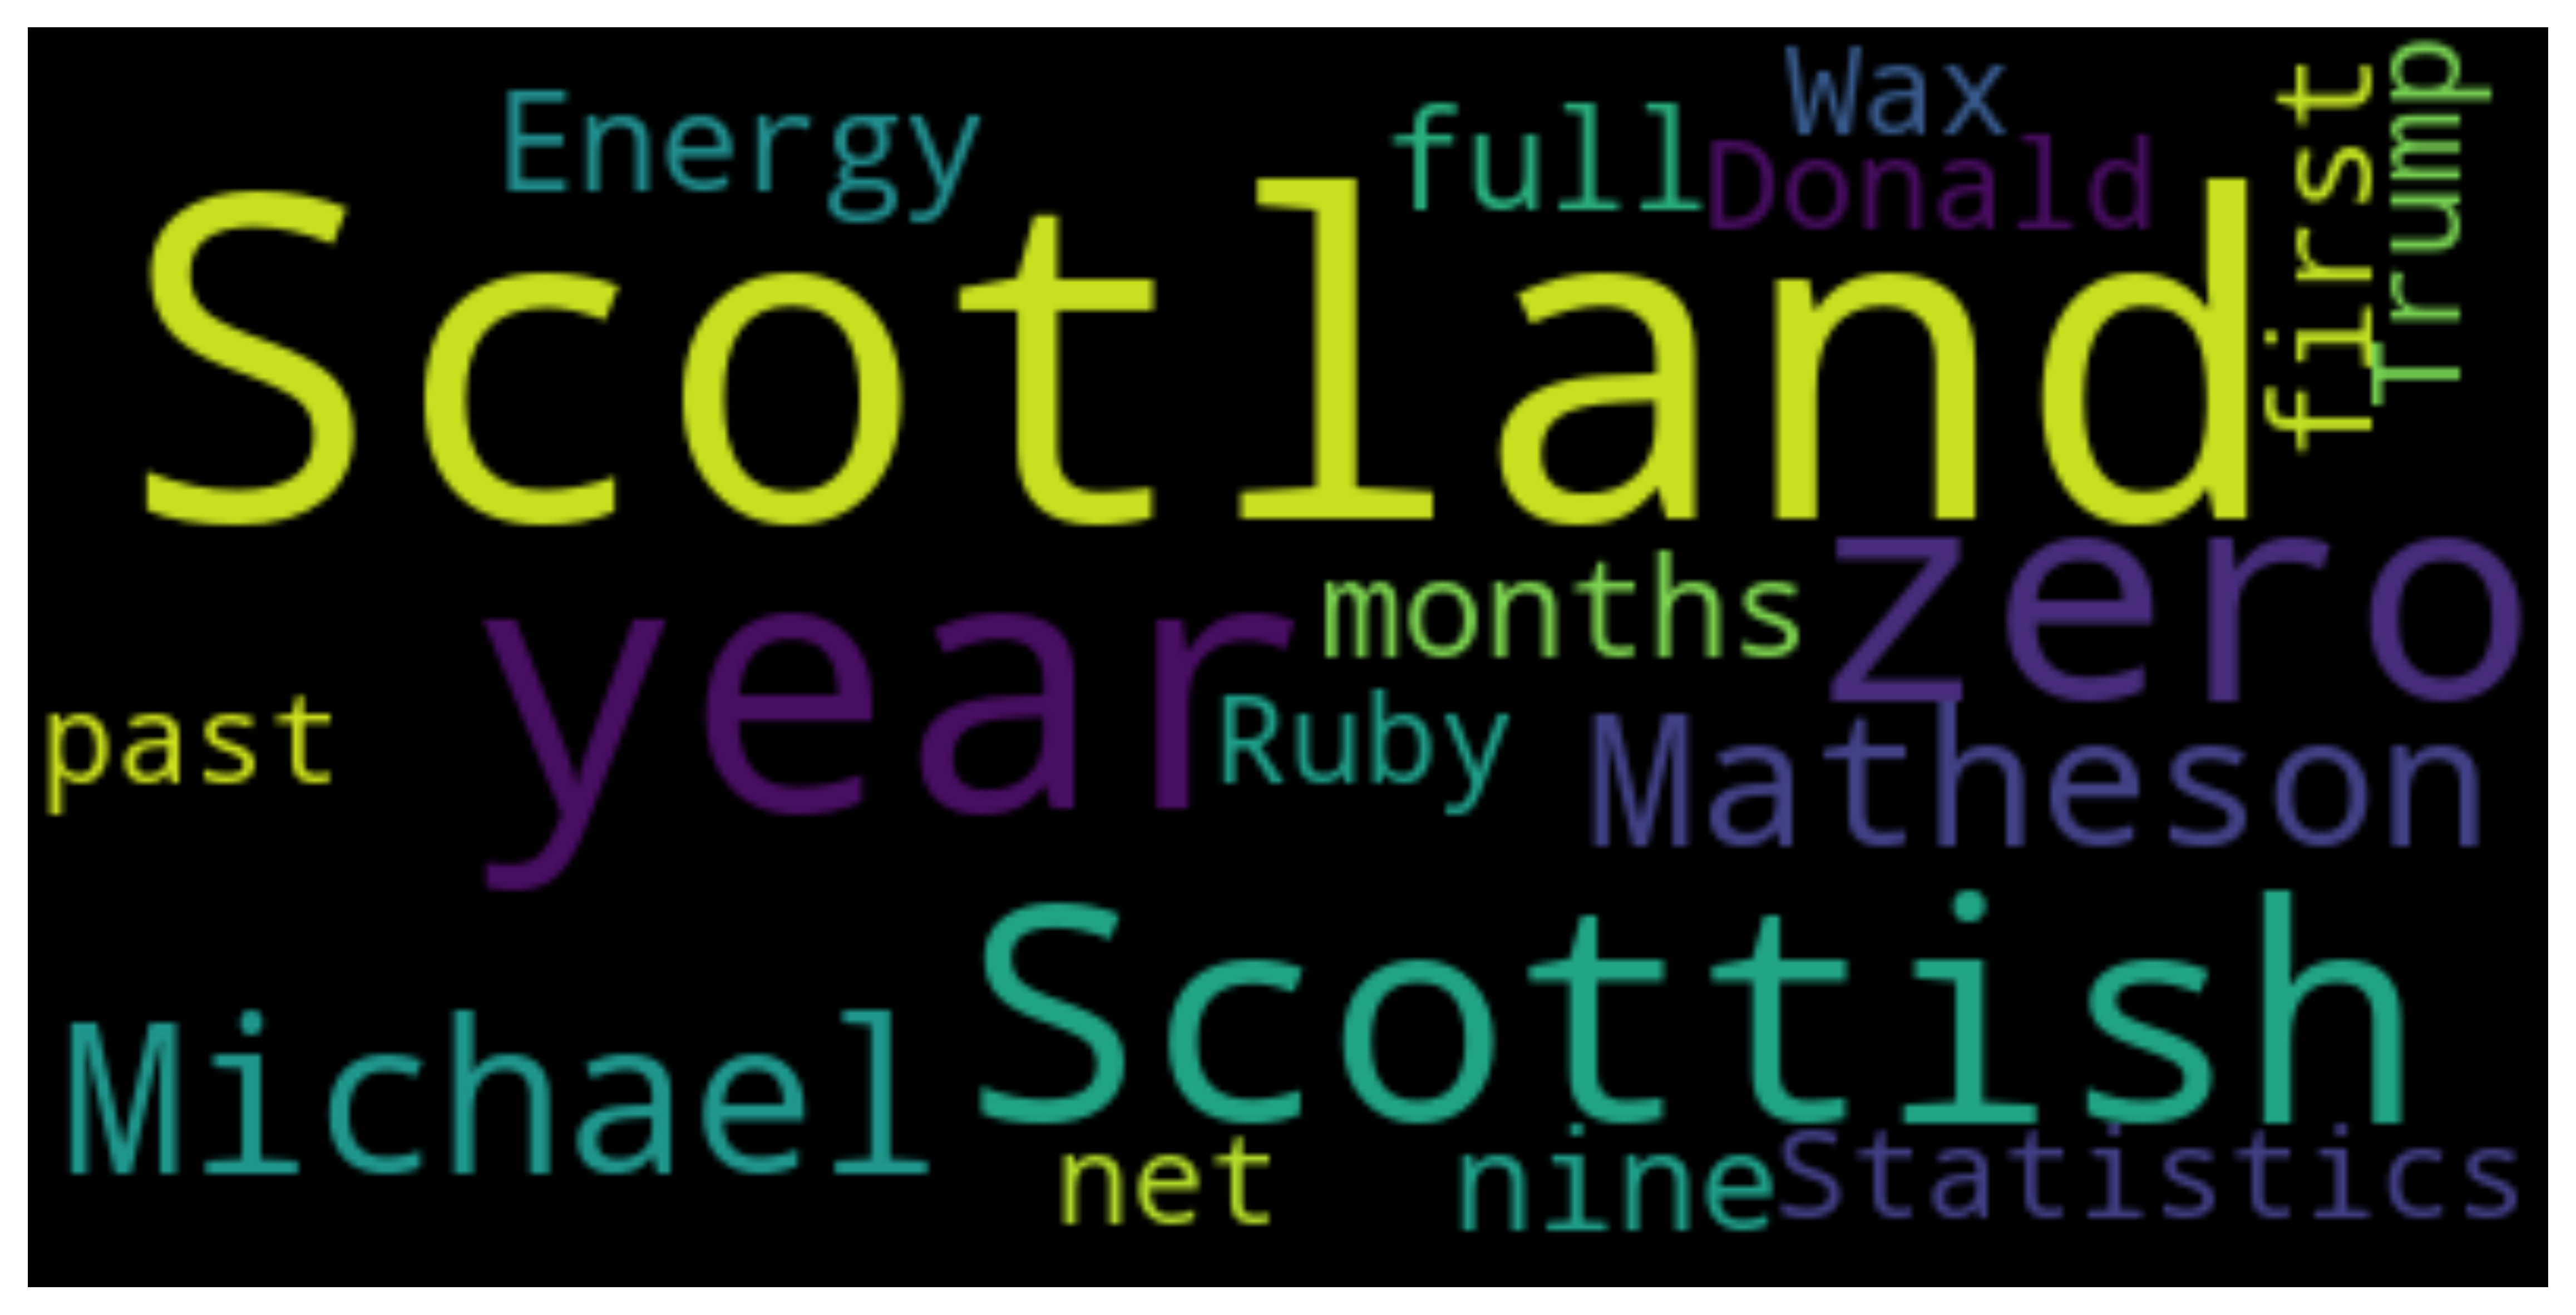

In [20]:
#Aranging named entites in a wordcloud
text = ' '.join([str(i) for i in get_Ner(str_)[0]['Entities'].to_list()])
wordcloud = WordCloud().generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(16, 6)
fig.set_dpi(500)
plt.show()

In [15]:
# fetch for results using a google api.
def NE_info_fetch(named_entity) -> str :
    url = "https://google-search26.p.rapidapi.com/search"
    Ne = named_entity
    querystring = {"q":Ne,"hl":"en","tbs":"qdr:a",'as_sitesearch':'wikipedia.com'}

    headers = {
        'x-rapidapi-host': "google-search26.p.rapidapi.com",
        'x-rapidapi-key': "ea42e2dcc0msh49ecba51860383ep18d94ejsnbb0488e12e70"
        }

    response = requests.request("GET", url, headers=headers, params=querystring)
    try:
        return (response.json()['results'][0]['snippet'][:300])
    except IndexError :
        return 'Wikipedia'
    
# get summary of two phrases ( topic sentence +1 ) in which the NER figured
def sumarize(List):
    result = []
    for _ in List:
        url = "https://api.meaningcloud.com/summarization-1.0"
        querystring = {"txt":_,"of":"json",'key':'1fe6342e2cfafb085d01802a50c98e6d','limit': 10}
        response = requests.request("GET", url, params=querystring)
        result.append(response.json()['summary'])
    return result

# get summary of phrases containning a certain named enitity
def get_summary(named_entity,index) -> List[str]:
    
    text = str(Data.iloc[index]['article_content'])
    phrases = nltk.tokenize.sent_tokenize(text)
    results = []
    for _ in range(len(phrases)):
        if named_entity in phrases[_]:
            results.append(phrases[_])
    return results

In [22]:
def ner_labelise(df) -> pd.DataFrame:
    ner_data = pd.DataFrame(columns = ['Named entities'])
    for _ in tqdm(range(len(df)), desc = 'NER'):
            try:
                text = Data['article_content'][_]
                person_summaries = get_Ner(text)[1]['Entities'].map(lambda x : [get_summary(str(x),_), NE_info_fetch(str(x))])
                countries_summaries = get_Ner(text)[2]['Entities'].map(lambda x : get_summary(str(x), _))
                organisations_summaries = get_Ner(text)[3]['Entities'].map(lambda x : [get_summary(str(x), _),NE_info_fetch(str(x))])
                persons = get_Ner(text)[1]['Entities'].tolist() , person_summaries.tolist()
                countries = get_Ner(text)[2]['Entities'].tolist(), countries_summaries.tolist()
                organisations = get_Ner(text)[3]['Entities'], countries_summaries.tolist()
                list_ner_data =  {'persons':persons, 'countries': countries, 'organisations':organisations}
                ner_data = ner_data.append({'NE summaries' :list_ner_data},ignore_index = True)
            except:
                pass
    return pd.concat([df,ner_data], axis = 1)
Labelised_ner_data = ner_labelise(Data)
#Labelised_ner_data.to_csv('exported_bbc_data-labelised.csv')
#Labelised_ner_data.to_excel('exported_bbc_data-labelised.xlsx')
#Labelised_ner_data['Named entities'][9]['countries']
Labelised_ner_data

,cathegory,author,title,Publish date,article_content,images descriptions,sentiment,Named entities,Named entities,NE summaries
0,COP26,Louise Cullen,Climate change: Will 2022 be the year NI gets legislation?,2022-01-02,Northern Ireland began 2021 without climate change legislation - and is ending the year with two...,"['Waterworks Park', 'A woman lifting weights', 'Man smiling', 'Police officers restrain a suppor...",3,"{'person': [Clare Bailey, Edwin Poots, Brexit, Taken, Waterworks, Antrim, Ruby Wax, Donald Trump...",NaN,"{'persons': ([Clare Bailey, Edwin Poots, Brexit, Waterworks, Antrim, Ruby Wax, Donald Trump], [[..."
1,COP26,BBC News,EU plans to label gas and nuclear energy 'green' prompt row,2022-01-02,"The European Commission has proposed plans to label some gas and nuclear power as green, prompti...","['A nuclear power plant in France', 'A woman lifting weights', 'Man smiling', 'Police officers r...",2,"{'person': [Steffi Lemke, Robert Habeck, Ruby Wax, Donald Trump], 'countries': 1 (Germany)\n...",NaN,"{'persons': ([Steffi Lemke, Robert Habeck, Ruby Wax, Donald Trump], [[['German Environment Minis..."
2,COP26,BBC News,Denmark to make domestic flights fossil fuel free by 2030,2022-01-02,Denmark's government has announced a goal to make domestic flights fossil fuel free by 2030. \nI...,"['SAS airlines planes', 'A woman lifting weights', 'Man smiling', 'Police officers restrain a su...",1,"{'person': [Mette Frederiksen, Ms Frederiksen, Ruby Wax, Donald Trump], 'countries': 0 (Denm...",NaN,"{'persons': ([Mette Frederiksen, Ms Frederiksen, Ruby Wax, Donald Trump], [[['In her New Year\'s..."
3,General,BBC News,Title of article,2022-01-02,A group of young men are using their gymnastic abilities to reduce the impact of light pollution...,"['Raven Cruz in Manila, Philippines', '', 'Luke and his daughter', 'Mel Chamberlain and a goat',...",3,"{'person': [Daniel South, Jasmin Souesi, Wizzy Gang], 'countries': 3 (France)\nName: Entities...",NaN,"{'persons': ([Daniel South, Jasmin Souesi, Wizzy Gang], [[['Video produced by Daniel South and J..."
4,General,BBC News,Title of article,2022-01-01,Jennifer Gardner and her family are among tens of thousands of people who have been evacuated as...,"['Wildfire razes a Colorado house', 'Overlooking the mountains', 'Mel Chamberlain and a goat', '...",1,"{'person': [Jennifer Gardner], 'countries': 2 (US)\n3 (Colorado)\nName: Entities, dt...",NaN,"{'persons': ([Jennifer Gardner], [[['Jennifer Gardner and her family are among tens of thousands..."
5,Our Planet Now,Justin Rowlatt,California's fires threaten to ravage mighty sequoia forests,2022-01-01,California's giant sequoias are symbols of permanence - with some living for thousands of years....,"['Dixie fire devastation in Greenville', 'A woman lifting weights', 'Man smiling', 'Police offic...",3,"{'person': [Christy Bingham, Christy, Christy, Christy, Nichoel Farris, Nichoel, Christy, Christ...",NaN,"{'persons': ([Christy Bingham, Christy, Christy, Christy, Christy, Nichoel Farris, Nichoel, Chri..."
6,Climate change,BBC News,Colorado wildfires: Tens of thousands evacuated as blazes spread,2021-12-31,"Tens of thousands of people have been evacuated and nearly 1,000 homes have been destroyed as wi...","[""Banner saying 'Get in touch'"", 'A woman lifting weights', 'Man smiling', 'Police officers rest...",1,"{'person': [Jared Polis, Gov Polis, Joe Biden, Joe Pelle, Snow, Gov Polis, Patrick Kilbride, Rub...",NaN,"{'persons': ([Jared Polis, Gov Polis, Joe Biden, Joe Pelle, Snow, Gov Polis, Patrick Kilbride, R..."
7,Climate change,BBC News,Scotland's 100% renewables electricity target narrowly missed,2021-12-31,Scotland narrowly missed a key environment target for the equivalent of 100% of electricity used...,"['wind turbines', 'A woman lifting weights', 'Man smiling', 'Police officers restrain a supporte...",1,"{'person': [Michael Matheson, Michael Matheson, Ruby Wax, Donald Trump], 'countries': 0 (Sco...",NaN,"{'persons': ([Michael Matheson, Mic

In [23]:
Labelised_ner_data['NE summaries'].iloc[5]


{'persons': ([Christy Bingham,
   Christy,
   Christy,
   Christy,
   Christy,
   Nichoel Farris,
   Nichoel,
   Christy,
   Ruby Wax,
   Donald Trump],
  [[['"They make you feel deep time", sighs Christy Bingham, as she looks up at the biggest tree in the world - known as the General Sherman.'],
    'View the profiles of people named Christy Bingham. Join Facebook to connect with Christy Bingham and others you may know. Facebook gives people the power...'],
   [['"They make you feel deep time", sighs Christy Bingham, as she looks up at the biggest tree in the world - known as the General Sherman.',
     'Christy lowers her voice as she says this, as if out of respect.',
     'Sequoias live so long because they are exquisitely adapted to their environment, Christy tells me.',
     'Christy leads me deeper into the forest, to show me what she means.',
     '"Before 2015 no one saw a sequoia that looked like this," says Christy.',
     'Christy wipes her tears with the sleeve of her jack


#### 2.3.2  Standford coreNlp  :

Installation and Configuration: https://medium.com/manash-en-blog/configuring-stanford-parser-and-stanford-ner-tagger-with-nltk-in-python-on-windows-f685483c374a

Stanford link: https://nlp.stanford.edu/software/CRF-NER.html

In [181]:
#entities_table = pd.concat([data_entities_2[['Entities','Labels']], info], axis=1) 
get_info = lambda x: [get_summary(x,Data,index),NE_info_fetch(x)]
get_info('Michael Matheson')

[['Energy Secretary Michael Matheson said the country continued to "lead the way" with its commitment to be net zero by 2045.',
  'In 2019, Scotland met 90.1% of its equivalent electricity consumption from renewables, according to Scottish government figures.',
  'Michael Matheson said he was "proud of the progress Scotland has made over the past year".',
  'The energy secretary added: "This statement shows we are continuing to make good progress with the equivalent of 98.6% of gross electricity consumption being from renewable sources in 2020, which is up from 89.8% in 2019.'],
 'Michael Stephen Matheson (born 8 September 1970) is a Scottish politician serving as Cabinet Secretary for Net Zero, Energy and Transport [n 1]since 2018.,,Early life, · ,Birth and education, · ,Member of the Scottish...,,,Children: ,3,,Majority: ,11,280 (35.1%),,Political party: ,Scottish National ']

In [138]:
#info = data_entities_2[["Entities",'Labels']]
#df_result = pd.DataFrame(columns = ['Entities','Labels','Text'])
#for _ in tqdm(info.iterrows()):
#    #it doesn't append idk whyn
#    #don't forget that the output of get info return a list of two list, its not a string , trying using another thing than iloc
#    info = get_info(_[1]['Entities'])
#    df_result = df_result.append(pd.DataFrame.from_dict({'Entities':_[1]['Entities'], 'Labels': _[1]['Labels'],'summary':info[0],'image description': info[1] }) , ignore_index=True)

In [182]:
#analyse sentiment of a text
def extract_sentiment(text) -> Tuple:
    java = "C:/Program Files/Java/jre1.8.0_311/bin/java.exe"
    os.environ["JAVAHOME"] = java
    annotators= 'tokenize,ssplit,pos,lemma,ner,parse,depparse,sentiment',
    # versions of Standford coreNlp
    corenlp432 =  "D:/stanford-corenlp-4.3.2/stanford-corenlp-4.3.2.jar/stanford-corenlp-4.3.2/stanford-corenlp-4.3.2.jar"
    os.environ["CORENLP_HOME"] = corenlp432
    nlp = StanfordCoreNLP('http://localhost', port=9000,timeout=30000)
    nlp_results = nlp.annotate(text,properties={
            'annotators':'sentiment,pos, ner',
            'outputFormat': 'json',
            'timeout': 50000,
            })
    json_results = json.loads(nlp_results)
    sentiment_description = json_results['sentences'][0]['sentiment']
    sentiment_value = json_results['sentences'][0]['sentimentValue']
    return sentiment_value

In [12]:
selected_df = Data

       Chars count
count    50.000000
mean   3270.320000
std    2380.123238
min     216.000000
25%    1668.500000
50%    3058.000000
75%    4632.250000
max    8451.000000


<AxesSubplot:>

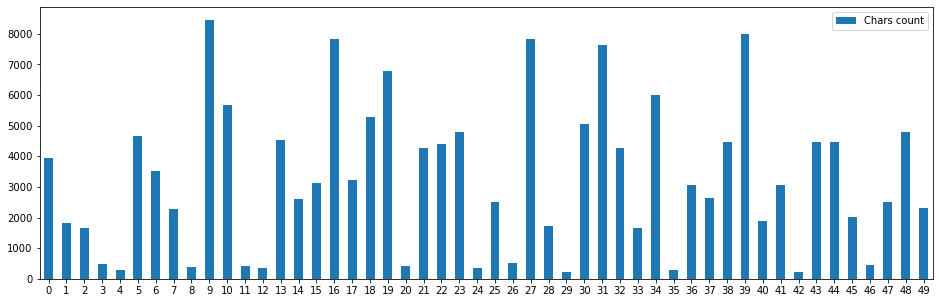

In [23]:
# A method to study the chars count distribution so to find the threshold to strip from oversized texts
# So to optimize the sentiment computing time
content = lambda index:Data.iloc[index]['article_content'] # Article sample
content_list  = [content(_) for _ in range(len(selected_df))]
Content_length_df = pd.DataFrame(map(len,content_list),columns = ['Chars count'])
print(Content_length_df.describe())
Content_length_df.plot.bar(y ='Chars count',figsize=(16,5), width=.5, rot=0)

In [185]:
#labelising articles with a sentiment measuring
def labelise_articles(df) -> pd.DataFrame:
    sentiment_data = pd.DataFrame(columns = ['sentiment'])
    for _ in tqdm(range(len(df)), desc = 'Analysing sentiment of articles'):
        text = selected_df['article_content'][_].replace('.',',')+','.join(selected_df['images descriptions'])
        if len(text)> 5000: #threshold
            text = text[:-len(text) // 3]
        try :
            sentiment_value = extract_sentiment(text)
        except:
            #sometimes, corenlp fails to measure the sentiment
            sentiment_value = rd.randint(1,3)
        sentiment_data = sentiment_data.append({'sentiment':sentiment_value},ignore_index = True)
    return pd.concat([df,sentiment_data], axis = 1)
Labelised_data = labelise_articles(selected_df)
Labelised_data.to_csv('exported_bbc_data-labelised.csv')
Labelised_data

,id,cathegory,author,title,Publish date,url,article_content,images descriptions,sentiment
0,0,COP26,Louise Cullen,Climate change: Will 2022 be the year NI gets legislation?,2022-01-02,https://www.bbc.com/news/uk-northern-ireland-59742532,Northern Ireland began 2021 without climate change legislation - and is ending the year with two...,"[Waterworks Park, A woman lifting weights, Man smiling, Police officers restrain a supporter of ...",3
1,1,COP26,BBC News,EU plans to label gas and nuclear energy 'green' prompt row,2022-01-02,https://www.bbc.com/news/world-europe-59850093,"The European Commission has proposed plans to label some gas and nuclear power as green, prompti...","[A nuclear power plant in France, A woman lifting weights, Man smiling, Police officers restrain...",2
2,2,COP26,BBC News,Denmark to make domestic flights fossil fuel free by 2030,2022-01-02,https://www.bbc.com/news/world-europe-59849898,Denmark's government has announced a goal to make domestic flights fossil fuel free by 2030. \nI...,"[SAS airlines planes, A woman lifting weights, Man smiling, Police officers restrain a supporter...",1
3,3,General,BBC News,Title of article,2022-01-02,https://www.bbc.com/news/world-europe-59755739,A group of young men are using their gymnastic abilities to reduce the impact of light pollution...,"[Raven Cruz in Manila, Philippines, , Luke and his daughter, Mel Chamberlain and a goat, Boris J...",3
4,4,General,BBC News,Title of article,2022-01-01,https://www.bbc.com/news/world-us-canada-59845176,Jennifer Gardner and her family are among tens of thousands of people who have been evacuated as...,"[Wildfire razes a Colorado house, Overlooking the mountains, Mel Chamberlain and a goat, Boris J...",1
5,5,Our Planet Now,Justin Rowlatt,California's fires threaten to ravage mighty sequoia forests,2022-01-01,https://www.bbc.com/news/science-environment-59842464,California's giant sequoias are symbols of permanence - with some living for thousands of years....,"[Dixie fire devastation in Greenville, A woman lifting weights, Man smiling, Police officers res...",3
6,6,Climate change,BBC News,Colorado wildfires: Tens of thousands evacuated as blazes spread,2021-12-31,https://www.bbc.com/news/world-us-canada-59834897,"Tens of thousands of people have been evacuated and nearly 1,000 homes have been destroyed as wi...","[Banner saying 'Get in touch', A woman lifting weights, Man smiling, Police officers restrain a ...",1
7,7,Climate change,BBC News,Scotland's 100% renewables electricity target narrowly missed,2021-12-31,https://www.bbc.com/news/uk-scotland-59837782,Scotland narrowly missed a key environment target for the equivalent of 100% of electricity used...,"[wind turbines, A woman lifting weights, Man smiling, Police officers restrain a supporter of th...",1
8,8,General,BBC News,Title of article,2021-12-31,https://www.bbc.com/news/world-us-canada-59837697,Wildfires have devastated parts of Boulder County in the US state of Colorado. Tens of thousands...,"[Sofia, Wildlife officer Scott Murdoch, Mel Chamberlain and a goat, Boris Johnson, Man smiling, ...",1
9,10,COP26,Martin Webber,Business Review of 2021: Climate change and Covid,2021-12-30,https://www.bbc.com/news/business-59730492,Over the past year governments all over the world told businesses to radically step up their str...,"[2px presentational grey line, A woman lifting weights, Man smiling, Police officers restrain a ...",1


In [188]:
Labelised_data.to_csv('exported_bbc_data-labelised.csv')
Labelised_data.to_excel('exported_bbc_data-labelised.xlsx')
Labelised_data.to_excel('dash_web_app/exported_bbc_data-labelised.xlsx')


In [5]:
labelised_data  = pd.read_csv('exported_bbc_data-labelised.csv')[['cathegory','title','Publish date', 'images descriptions','sentiment','Named entities']]
labelised_data.head()

,cathegory,title,Publish date,images descriptions,sentiment,Named entities
0,COP26,Climate change: Will 2022 be the year NI gets ...,2022-01-02,"['Waterworks Park', 'A woman lifting weights',...",3,"{'person': [Clare Bailey, Edwin Poots, Brexit,..."
1,COP26,EU plans to label gas and nuclear energy 'gree...,2022-01-02,"['A nuclear power plant in France', 'A woman l...",2,"{'person': [Steffi Lemke, Robert Habeck, Ruby ..."
2,COP26,Denmark to make domestic flights fossil fuel f...,2022-01-02,"['SAS airlines planes', 'A woman lifting weigh...",1,"{'person': [Mette Frederiksen, Ms Frederiksen,..."
3,General,Title of article,2022-01-02,"['Raven Cruz in Manila, Philippines', '', 'Luk...",3,"{'person': [Daniel South, Jasmin Souesi, Wizzy..."
4,General,Title of article,2022-01-01,"['Wildfire razes a Colorado house', 'Overlooki...",1,"{'person': [Jennifer Gardner], 'countries': 2 ..."


In [ ]:
# A function to store the summary of phrase 

In [6]:
def git_update():
    !git commit -am "Minor changes"
    !git push
    print('changes updated succesfully on git.')
git_update()

[main 64fafc0] Minor changes
 3 files changed, 251 insertions(+), 2047 deletions(-)


The file will have its original line endings in your working directory
The file will have its original line endings in your working directory
The file will have its original line endings in your working directory


changes updated succesfully on git.


To https://github.com/oussamasmihrou/bbcguardian.git
   796fb1d..64fafc0  main -> main
